In [1]:
!nvidia-smi

Wed May  6 16:54:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
pip install transformers

     |████████████████████████████████| 573kB 2.8MB/s 
     |████████████████████████████████| 1.0MB 12.4MB/s 
     |████████████████████████████████| 890kB 15.8MB/s 
     |████████████████████████████████| 3.7MB 21.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=dfef679a2f9fb21c28ac922c35841b73d4408e0ac35f80f1079abe2690dbf0b3
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


Special thanks to Venelin Valkov on Youtube for part of the code

In [3]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from string import digits
import re

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn.functional as F
from torch.autograd import Variable

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 24
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
PRE_TRAINED_MODEL = 'bert-base-uncased'
BATCH_SIZE = 8

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


device(type='cuda', index=0)

# Max token length

In [0]:
attributes_df=pd.read_csv('attributes_df.csv')
#style_df=pd.read_csv('style_df.csv')
#tagged_products_df=pd.read_csv('tagged_products_df.csv')

In [0]:
brand_dummies = pd.get_dummies(attributes_df['brand_le'])

In [0]:
attributes_df = pd.concat([attributes_df, brand_dummies],axis=1).drop('brand_le', axis=1)

In [7]:
cols = ['description','product_full_name']#, 'brand', 'name']
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)
#tokenizer = tokenizer = transformers.RobertaTokenizer.from_pretrained('/content/',max_len=MAXLEN)

In [0]:
def token_length(row, cols, tokenizer):
  token_len = 0
  for col in cols:
    token_len += len(tokenizer.encode(str(row[col]), max_length=512))
  return token_len

In [0]:
token_lens = attributes_df.apply(lambda row: token_length(row, cols, tokenizer), axis=1)

***Here we can do something to see how to shrink the longer token len rows***

Text(0.5, 0, 'Token count')

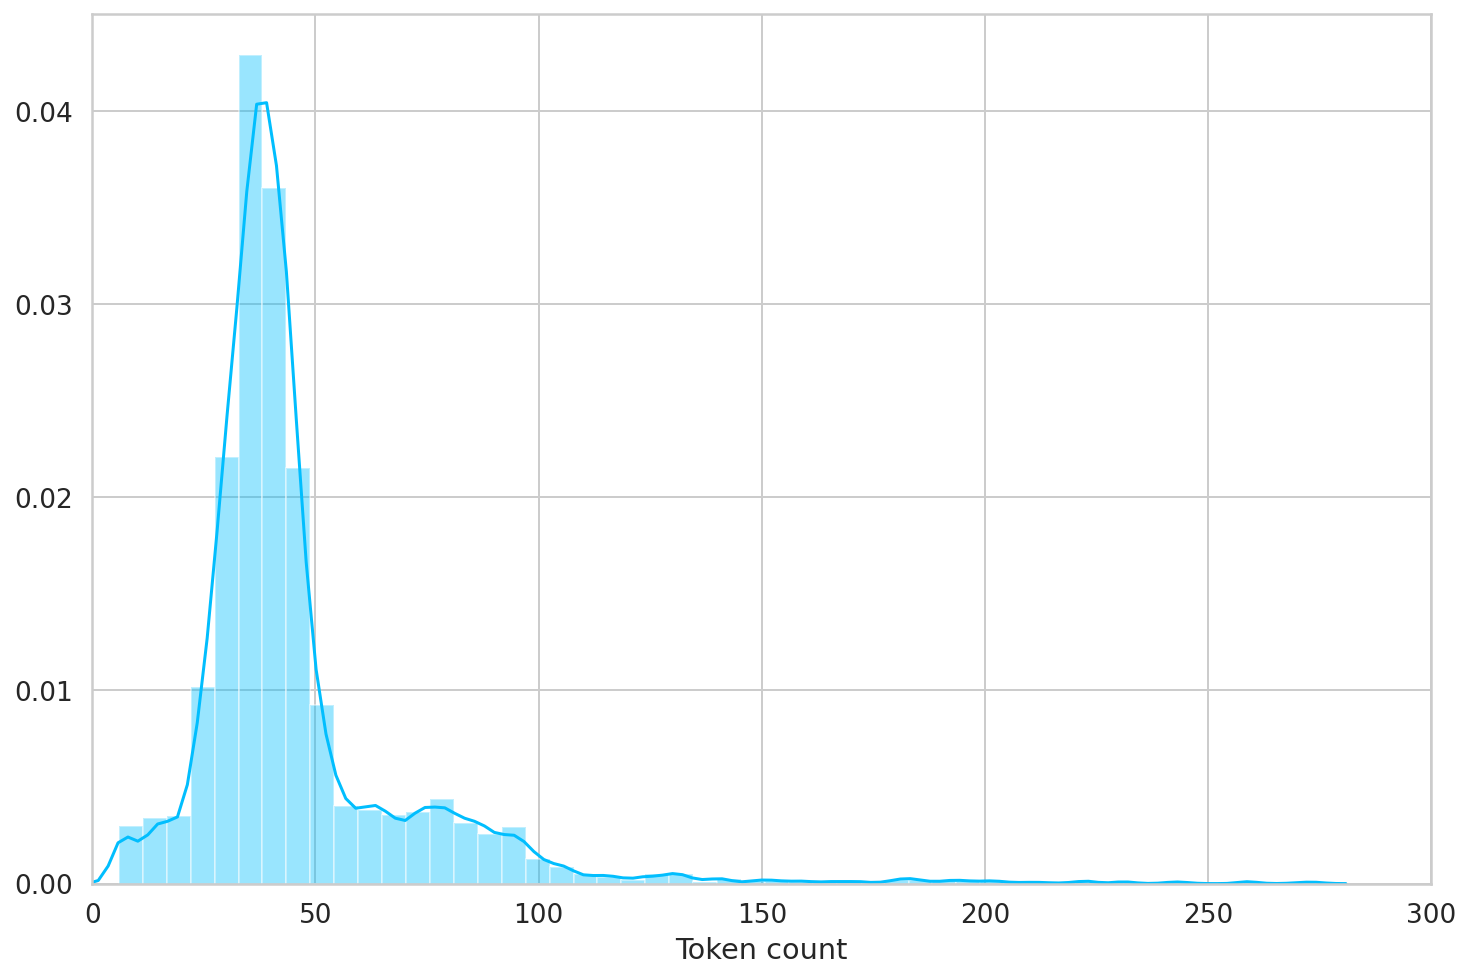

In [10]:
sns.distplot(token_lens)
plt.xlim([0, 300]);
plt.xlabel('Token count')

In [0]:
MAXLEN = 130

# Deep learning models

In [0]:
# architecture cred to: https://towardsdatascience.com/identifying-hate-speech-with-bert-and-cnn-b7aa2cddd60d?gi=760198ca9051
class BERTBaseUncasedCNN(nn.Module):
  def __init__(self, embed_num, embed_dim, class_num, kernel_num, kernel_sizes, dropout, static):
    super(BERTBaseUncasedCNN, self).__init__()
    self.bert = transformers.BertModel.from_pretrained(PRE_TRAINED_MODEL)
    self.V = embed_num
    self.D = embed_dim
    self.C = class_num
    self.Co = kernel_num
    self.Ks = kernel_sizes
    self.static = static
    self.cat_len = 482
    self.convs1 = nn.ModuleList([nn.Conv2d(1, self.Co, (K, self.D)) for K in self.Ks])
    self.dropout = nn.Dropout(dropout)
    self.fc1 = nn.Linear(len(self.Ks) * self.Co + len(categories), 64)
    self.fc2 = nn.Linear(64, 16)
    self.fc3 = nn.Linear(16, 1)

  def forward(self, input_ids, attention_mask, category):
    x, _ = self.bert(
        input_ids=input_ids, 
        attention_mask=attention_mask)
    if self.static:
      x = Variable(x)
    x = x.unsqueeze(1)
    x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]
    x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
    x = torch.cat(x, 1)
    x = torch.cat((category.view(-1,self.cat_len),x),dim=1)
    x = self.dropout(x)
    x = x.view(-1, len(self.Ks) * self.Co + len(categories))
    x = self.fc1(x)
    x = self.fc2(x)
    return self.fc3(x)
  def resize_token_embeddings(self, tokenizer_len):
    self.bert.resize_token_embeddings(tokenizer_len)

In [0]:
#this is using self-trained roberta model using scraped descriptions from Farfetch
class Clothberta(nn.Module): 
  def __init__(self, dropout):
    super(Clothberta, self).__init__()
    self.roberta = transformers.RobertaModel.from_pretrained('/content/')
    self.cat_len = 482
    self.dropout = nn.Dropout(p=dropout)
    self.hidden1 = nn.Linear(self.roberta.config.hidden_size + self.cat_len, 64)
    self.hidden2 = nn.Linear(64, 16)
    self.out = nn.Linear(16, 1)
    # self.out2 = nn.Linear(self.roberta.config.hidden_size + self.cat_len, 1)

  def forward(self, input_ids, attention_mask, category):
    _, x = self.roberta(
        input_ids=input_ids, 
        attention_mask=attention_mask)
    x = torch.cat((category.view(-1,self.cat_len),x),dim=1)
    x = self.dropout(x)
    x = x.view(-1, self.roberta.config.hidden_size + self.cat_len)
    x = self.hidden1(x)
    x = self.hidden2(x)
    return self.out(x)
  def resize_token_embeddings(self, tokenizer_len):
    self.roberta.resize_token_embeddings(tokenizer_len)

In [0]:
#regular dense model with bert 
class BERTBaseUncased(nn.Module):
  def __init__(self, dropout):
    super(BERTBaseUncased, self).__init__()
    self.bert = transformers.BertModel.from_pretrained(PRE_TRAINED_MODEL)
    self.cat_len = 482
    self.dropout = nn.Dropout(p=dropout)
    self.hidden1 = nn.Linear(self.bert.config.hidden_size + self.cat_len, 64)
    self.hidden2 = nn.Linear(64, 16)
    self.out = nn.Linear(16, 1)
    # self.out2 = nn.Linear(self.bert.config.hidden_size + self.cat_len, 1)

  def forward(self, input_ids, attention_mask, category):
    _, x = self.bert(
        input_ids=input_ids, 
        attention_mask=attention_mask)
    x = torch.cat((category.view(-1,self.cat_len),x),dim=1)
    x = self.dropout(x)
    x = x.view(-1, self.bert.config.hidden_size + self.cat_len)
    x = self.hidden1(x)
    x = self.hidden2(x)
    return self.out(x)
  def resize_token_embeddings(self, tokenizer_len):
    self.bert.resize_token_embeddings(tokenizer_len)

In [0]:
class StyleDataLoader:
  def __init__(self, item_desc, brand_category, name, targets, tokenizer, max_length):
    self.item_desc = item_desc
    self.brand_category = brand_category
    self.name = name
    self.tokenizer = tokenizer
    self.max_length = max_length
    self.targets = targets
  
  def __len__(self):
    return len(self.item_desc)
    
  def __getitem__(self, item):
    item_description = str(self.item_desc[item])
    item_brand_category = self.brand_category[item]
    item_name = str(self.name[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
        item_description, item_name,
        max_length=self.max_length,
        add_special_tokens=True,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    return {
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'targets': torch.tensor(target, dtype=torch.long),
        'brand_category':torch.tensor(item_brand_category, dtype=torch.float)
    }

In [0]:
#tokenizer = transformers.RobertaTokenizer.from_pretrained('/content/',max_len=MAXLEN)
#bert tokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)

In [0]:
#train test split
df_train, df_val = train_test_split(attributes_df, stratify=attributes_df.weekend_target,random_state=RANDOM_SEED, test_size=0.1)
df_val, df_test = train_test_split(df_val, stratify=df_val.weekend_target,random_state=RANDOM_SEED, test_size=0.5)

In [0]:
# experimenting with oversampling
# from imblearn.over_sampling import RandomOverSampler
# ros = RandomOverSampler(random_state=24)

# X_res, _ = ros.fit_resample(df_train, df_train.weekend_target)
# X_res = pd.DataFrame(X_res)
# X_res.columns = df_train.columns

In [19]:
df_train.shape, df_val.shape, df_test.shape

((3276, 494), (182, 494), (183, 494))

In [0]:
categories = df_train.iloc[:,12:].columns.tolist()

In [0]:
def create_data_loader(df, target, tokenizer, max_len, batch_size, categories, weighted_sampler=None):
  dataset = StyleDataLoader(item_desc=df.description.to_numpy(),
                brand_category=df[categories].to_numpy().astype(float),
                name=df.product_full_name.to_numpy(),
                targets=df[target].to_numpy().astype(float).reshape(-1,1),
                tokenizer=tokenizer,
                max_length=MAXLEN)
  return DataLoader(
      dataset,
      sampler=weighted_sampler,
      batch_size=batch_size)

In [0]:
# calculating class imbalance and add in weighted sampler for train data loader
class_weights = 1 / df_train['weekend_target'].value_counts()
class_index = df_train['weekend_target'].value_counts().index
weights_map = {class_index[i]:class_weights.iloc[i] for i in range(len(class_index))}
class_weights_all = df_train['weekend_target'].map(weights_map).tolist()

In [0]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [0]:
#weighted sampler to treat class imbalance
train_data_loader = create_data_loader(df_train, 'weekend_target', tokenizer, MAXLEN, BATCH_SIZE, categories=categories, weighted_sampler=weighted_sampler)
val_data_loader = create_data_loader(df_val, 'weekend_target', tokenizer, MAXLEN, BATCH_SIZE, categories=categories)
test_data_loader = create_data_loader(df_test, 'weekend_target', tokenizer, MAXLEN, BATCH_SIZE, categories=categories)

In [0]:
# num_added_toks = tokenizer.add_tokens(['CATEGORY_TOKEN', 'NAME_TOKEN'])
# weekendmodel.resize_token_embeddings(len(tokenizer))

In [26]:
# model config
# embed_num = MAXLEN
# embed_dim = transformers.BertModel.from_pretrained(PRE_TRAINED_MODEL).config.hidden_size#transformers.RobertaModel.from_pretrained('/content/').config.hidden_size
# class_num = 1
# kernel_num = 3
# kernel_sizes = [2,3,4]
# dropout = 0.3
# static = True
weekendmodel = BERTBaseUncased(dropout=dropout)
weekendmodel = weekendmodel.to(device)

In [0]:
#define optimizer, scheduler, loss function 
EPOCHS = 20
optimizer = AdamW(weekendmodel.parameters(),
          lr=2e-5,
          correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps)

loss_fn = nn.BCEWithLogitsLoss().to(device)

In [0]:
def get_accuracy(y_true, y_pred):
  return (y_true == y_pred).sum().float() / len(y_true)

In [0]:
from sklearn.metrics import f1_score
def get_f1(y_true, y_pred):
  return f1_score(y_true, y_pred)

In [0]:
def train_epoch(model, data_loader, loss_fn, optimizer, 
        device, scheduler, n_examples):
  model = model.train()
  
  losses = []
  cumm_accuracy = 0
  labels, predictions = [], []

  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets'].to(device)
    brand_category = d['brand_category'].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      category=brand_category
    )

    preds = torch.sigmoid(outputs).ge(0.5).view(-1)
    predictions.extend(preds.cpu())
    labels.extend(targets.cpu())

    loss = loss_fn(outputs, targets.type_as(outputs))
    cumm_accuracy += get_accuracy(targets, preds)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    # clipping grads for to prevent exploding grad
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer.step()
    scheduler.step()

  epoch_f1 = get_f1(labels, predictions)
  return cumm_accuracy.double() / n_examples, np.mean(losses), epoch_f1

In [0]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  predictions, labels = [], []
  cumm_accuracy = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      targets = d['targets'].to(device)
      brand_category = d['brand_category'].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        category=brand_category
      )
      #keep track of predictions
      preds = torch.sigmoid(outputs).ge(0.5).view(-1)
      predictions.extend(preds.cpu())
      labels.extend(targets.cpu())

      #losses and eval metrics
      loss = loss_fn(outputs, targets.type_as(outputs))
      cumm_accuracy += get_accuracy(targets, preds)
      losses.append(loss.item())
  epoch_f1 = get_f1(labels, predictions)
  return cumm_accuracy.double() / n_examples, np.mean(losses), epoch_f1

In [0]:
torch.cuda.empty_cache()

In [63]:
# main training loop
%%time

history = defaultdict(list)
best_f1 = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss, train_f1 = train_epoch(
    weekendmodel,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} train acc {train_acc} f1 {train_f1}')

  val_acc, val_loss, val_f1 = eval_model(
    weekendmodel,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val loss {val_loss} val acc {val_acc} f1 {val_f1}')
  print()

  history['train_f1'].append(train_f1)
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_f1'].append(val_f1)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_f1 > best_f1:
    torch.save(weekendmodel.state_dict(), 'weekend_model_state.bin')
    best_f1 = val_f1

Epoch 1/20
----------
Train loss 0.2895409918322069 train acc 0.5538003663003663 f1 0.9120384268988293
Val loss 0.7602800909915696 val acc 0.6291208791208792 f1 0.8444444444444443

Epoch 2/20
----------
Train loss 0.23668217998588595 train acc 0.556013431013431 f1 0.9341133004926109
Val loss 0.9107613736844581 val acc 0.6565934065934066 f1 0.8398576512455516

Epoch 3/20
----------
Train loss 0.1563197250273533 train acc 0.5562423687423688 f1 0.9639905548996457
Val loss 1.0309395570226985 val acc 0.6662087912087913 f1 0.85

Epoch 4/20
----------
Train loss 0.13145438975586396 train acc 0.5590659340659341 f1 0.9705973382853605
Val loss 1.1316910193139769 val acc 0.6552197802197802 f1 0.8447653429602888

Epoch 5/20
----------
Train loss 0.1114886705570559 train acc 0.5587606837606838 f1 0.976459798226842
Val loss 1.120602117082023 val acc 0.6456043956043956 f1 0.8498168498168498

Epoch 6/20
----------
Train loss 0.10472475892023705 train acc 0.5563186813186813 f1 0.9783147459727385
Val lo

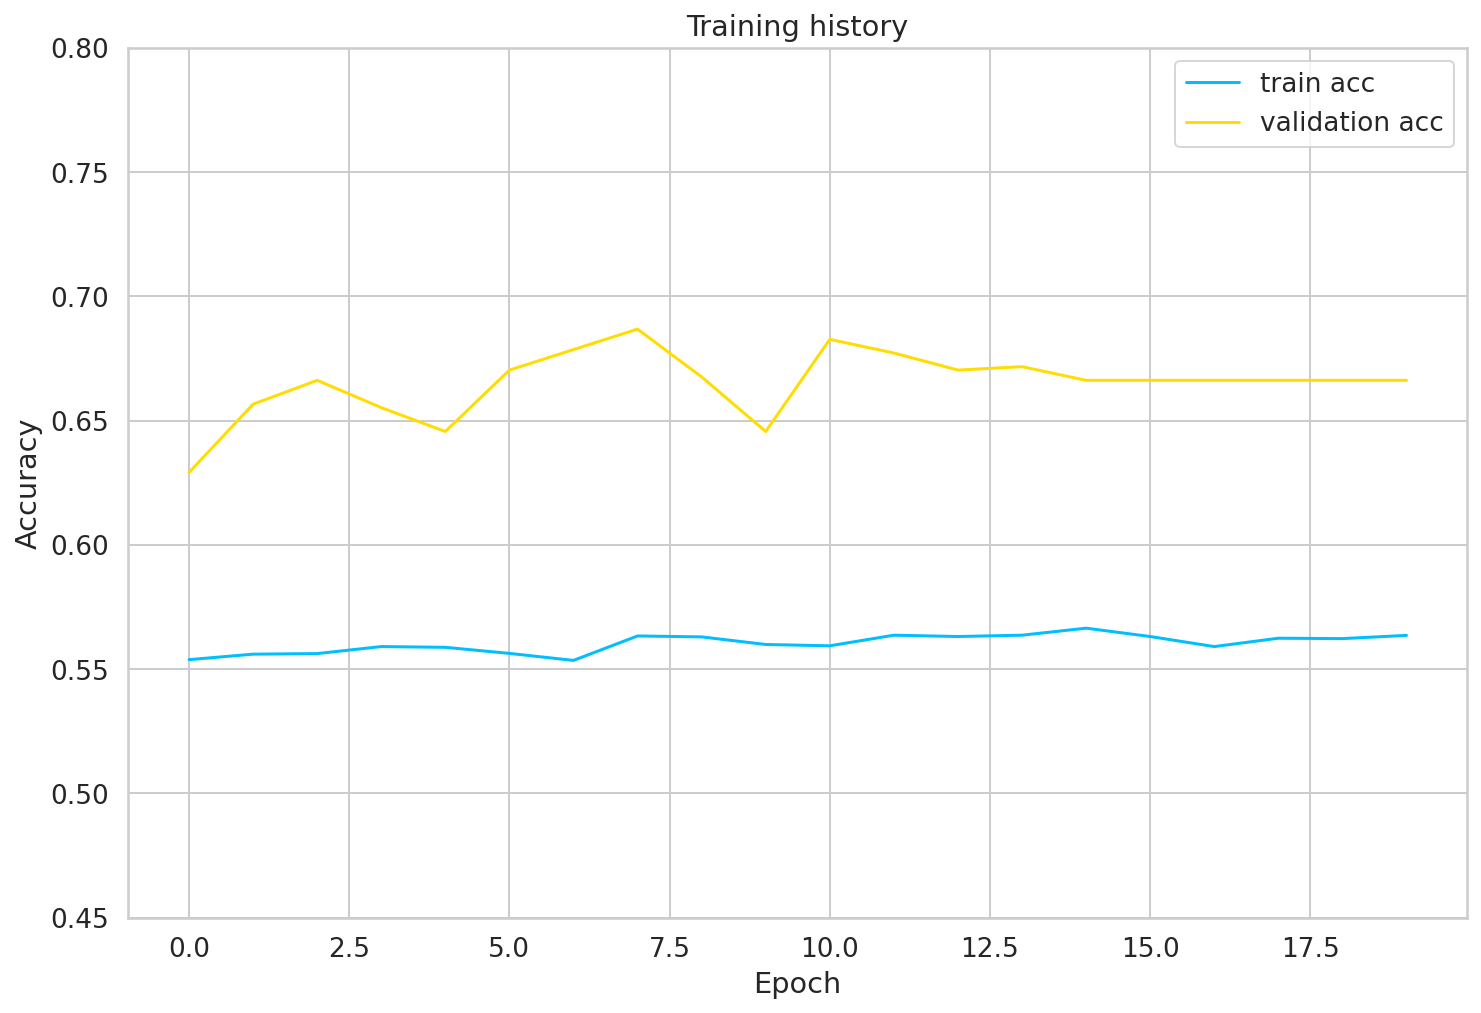

In [64]:
plt.plot(history['train_acc'], label='train acc')
plt.plot(history['val_acc'], label='validation acc')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.45, 0.8]);

In [65]:
_, _, test_f1 = eval_model(
  weekendmodel,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_f1.item()

0.872852233676976

In [0]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      brand_category = d['brand_category'].to(device)


      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        category=brand_category
      )

      probs = torch.sigmoid(outputs)
      preds = probs.ge(0.5).view(-1)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, prediction_probs, real_values

In [0]:
y_pred, y_pred_probs, y_test = get_predictions(
  weekendmodel,
  test_data_loader
)

In [68]:
print(classification_report(y_test, y_pred, target_names=['1','0']))

              precision    recall  f1-score   support

           1       0.61      0.43      0.51        44
           0       0.84      0.91      0.87       139

    accuracy                           0.80       183
   macro avg       0.72      0.67      0.69       183
weighted avg       0.78      0.80      0.78       183



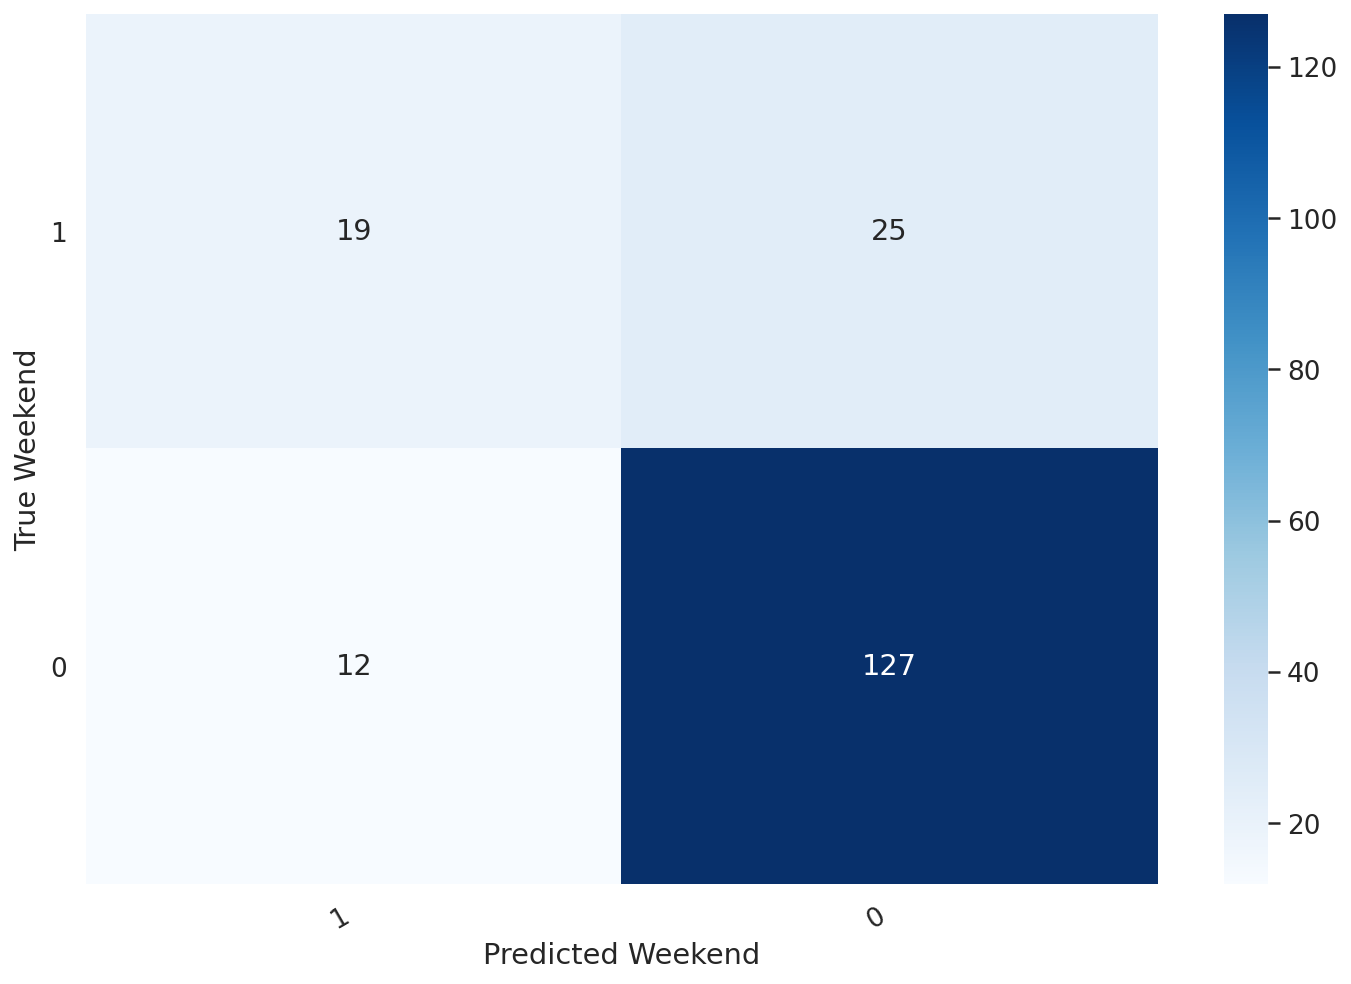

In [70]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Weekend')
  plt.xlabel('Predicted Weekend');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=['1','0'], columns=['1','0'])
show_confusion_matrix(df_cm)

# Deploy

In [0]:
class_weights = 1 / attributes_df['weekend_target'].value_counts()
class_index = attributes_df['weekend_target'].value_counts().index
weights_map = {class_index[i]:class_weights.iloc[i] for i in range(len(class_index))}
class_weights_all = attributes_df['weekend_target'].map(weights_map).tolist()
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True)
full_data_loader = create_data_loader(attributes_df, 'weekend_target', tokenizer, MAXLEN, BATCH_SIZE, categories=categories, weighted_sampler=weighted_sampler)

In [0]:
final_weekend_model = BERTBaseUncased(dropout=dropout)
final_weekend_model = final_weekend_model.to(device)

In [0]:
#define optimizer, scheduler, loss function 
EPOCHS = 10
optimizer = AdamW(final_weekend_model.parameters(),
          lr=2e-5,
          correct_bias=False)
total_steps = len(full_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps)

loss_fn = nn.BCEWithLogitsLoss().to(device)

In [77]:
%%time

history = defaultdict(list)

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss, train_f1 = train_epoch(
    final_weekend_model,
    full_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(attributes_df)
  )
  print(f'Train loss {train_loss} accuracy {train_acc} f1 {train_f1}')

  history['train_f1'].append(train_f1)
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
torch.save(final_weekend_model.state_dict(), 'final_weekend_model_state.bin')

Epoch 1/10
----------
Train loss 0.6958004663649359 accuracy 0.49691018950837684 f10.4717647058823529
Epoch 2/10
----------
Train loss 0.6918920394882822 accuracy 0.4965668772315298 f10.5583501006036218
Epoch 3/10
----------
Train loss 0.6652705811225531 accuracy 0.5104366932161494 f10.5723342939481268
Epoch 4/10
----------
Train loss 0.5348481867266329 accuracy 0.5354984894259819 f10.7714817770683693
Epoch 5/10
----------
Train loss 0.4643472102062221 accuracy 0.5389316121944521 f10.8182801514332072
Epoch 6/10
----------
Train loss 0.37231805165739434 accuracy 0.5394809118374073 f10.8671831765356947
Epoch 7/10
----------
Train loss 0.29984057068890124 accuracy 0.5481323812139522 f10.9055007052186177
Epoch 8/10
----------
Train loss 0.25490567582790136 accuracy 0.5498489425981873 f10.9264044943820225
Epoch 9/10
----------
Train loss 0.22052486909128594 accuracy 0.5522521285361165 f10.9392826885060718
Epoch 10/10
----------
Train loss 0.1791477819063227 accuracy 0.5547926393847844 f10.9

In [0]:
from google.colab import files
files.download('weekend_model_state.bin')
files.download('final_weekend_model_state.bin')

Lower accuracy model with decent F1 score because trained with weighted sampler. This model will have a good tradeoff between precision/recall instead of predicting all 0's if without weighted sampler that optimizes for accuracy.